### 1. Predicting Temperature

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [4]:
weather_df[['humidity','windspeed','windbearing','pressure']].describe()

,humidity,windspeed,windbearing,pressure
count,96453.000,96453.000,96453.000,96453.000
mean,0.735,10.811,187.509,1003.236
std,0.195,6.914,107.383,116.970
min,0.000,0.000,0.000,0.000
25%,0.600,5.828,116.000,1011.900
50%,0.780,9.966,180.000,1016.450
75%,0.890,14.136,290.000,1021.090
max,1.000,63.853,359.000,1046.380


In [7]:
weather_df.isnull().sum()*100/weather_df.count()

date                  0.000
summary               0.000
preciptype            0.000
temperature           0.000
apparenttemperature   0.000
humidity              0.000
windspeed             0.000
windbearing           0.000
visibility            0.000
loudcover             0.000
pressure              0.000
dailysummary          0.000
dtype: float64

In [8]:
Y = weather_df['temperature']
X = weather_df[['humidity','windspeed','windbearing','pressure']]

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.9264381852854


In [9]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -6.282637831541205e-15


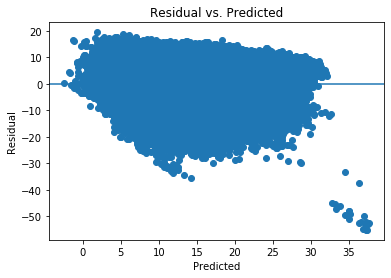

In [10]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [11]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


From our plot above as well as the Bartlett and Levene tests, it appears that our model is heteroscedactic. To fix our model, we could do Box-Cox transformations on the data.

In [12]:
weather_df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060
loudcover,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000


Our model meets the assumptions of low collinearity. None of our independent variables are correlated with one another.

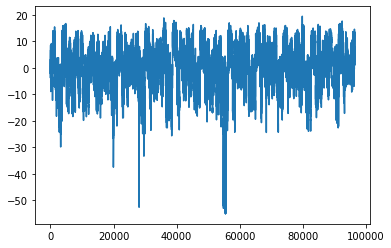

In [13]:
plt.plot(errors)
plt.show()

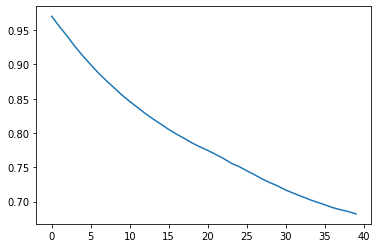

In [14]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

From the acf plot above, it seems that our errors do share some correlation with one another. The correlation ranges from very high (.95) to fairly high (.7).

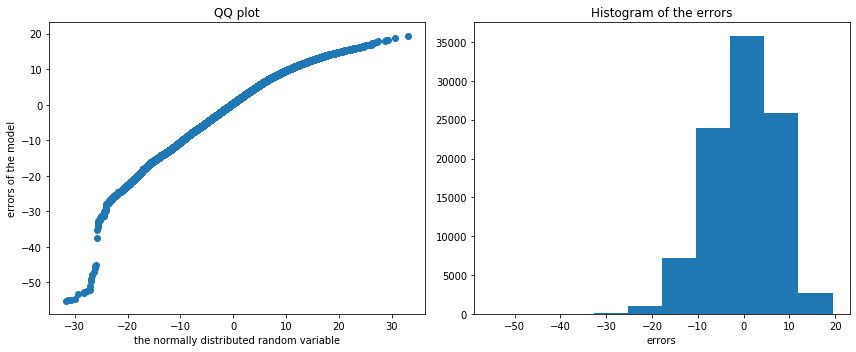

In [15]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252366 and p value is 0.0
Normality test statistics is 3375.432307699586 and p value is 0.0


Thankfully, our errors are not normally distributed.

### 2. House Prices

In [17]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [18]:
housing_df = pd.concat([housing_df,pd.get_dummies(housing_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
housing_df = pd.concat([housing_df,pd.get_dummies(housing_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(housing_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(housing_df.street, prefix="street", drop_first=True).columns)

In [20]:
X = housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = housing_df.saleprice

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.33265353e+04 4.56343565e+01 1.34501364e+04 1.64082048e+01
 2.83816393e+01 2.50875137e+04 1.34204564e+04 2.85658560e+04
 9.04778936e+03 1.51037622e+02]

Intercept: 
 -117337.72871399301


In [21]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -3.0957704588566744e-11


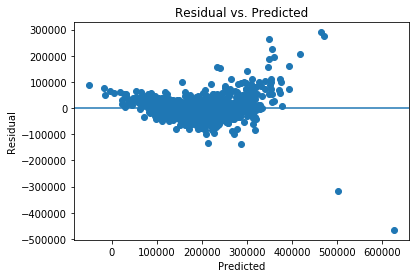

In [22]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [23]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


In [26]:
housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names].corr()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
overallqual,1.000,0.593,0.601,0.562,0.538,0.172,-0.065,0.127,-0.196,0.059
grlivarea,0.593,1.000,0.467,0.469,0.455,0.024,-0.001,0.133,-0.154,0.044
garagecars,0.601,0.467,1.000,0.882,0.435,0.103,-0.090,0.175,-0.222,-0.020
garagearea,0.562,0.469,0.882,1.000,0.487,0.115,-0.073,0.170,-0.236,-0.048
totalbsmtsf,0.538,0.455,0.435,0.487,1.000,-0.033,-0.055,0.257,-0.247,0.005
mszoning_FV,0.172,0.024,0.103,0.115,-0.033,1.000,-0.023,-0.417,-0.090,0.014
mszoning_RH,-0.065,-0.001,-0.090,-0.073,-0.055,-0.023,1.000,-0.203,-0.044,0.007
mszoning_RL,0.127,0.133,0.175,0.170,0.257,-0.417,-0.203,1.000,-0.809,0.045
mszoning_RM,-0.196,-0.154,-0.222,-0.236,-0.247,-0.090,-0.044,-0.809,1.000,-0.003
street_Pave,0.059,0.044,-0.020,-0.048,0.005,0.014,0.007,0.045,-0.003,1.000


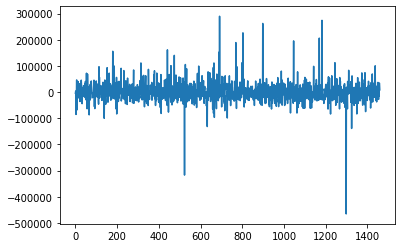

In [27]:
plt.plot(errors)
plt.show()

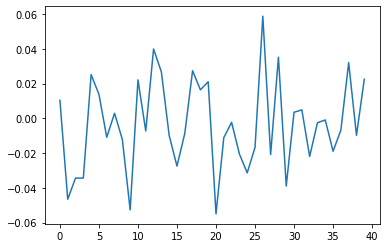

In [28]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

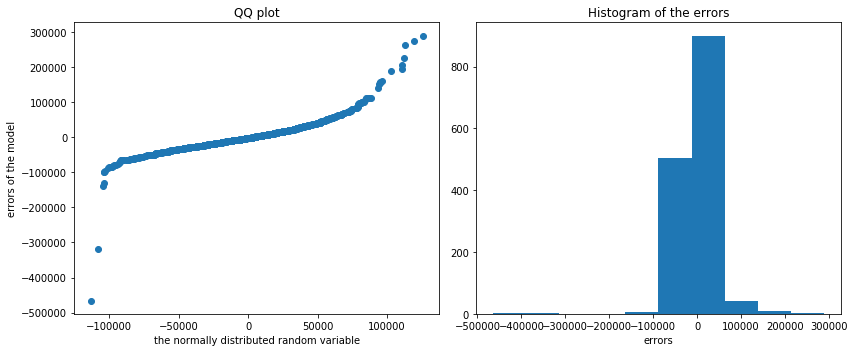

In [29]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [30]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.526018267796 and p value is 0.0
Normality test statistics is 415.8826568586338 and p value is 4.922984898056951e-91


Our errors are not normally distributed.